In [1]:
# Hierarchical Clustering Analysis for Portfolio Management
# Comparison of Bottom-up vs Top-down Approaches

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.preprocessing import StandardScaler
import yfinance as yf
from fastcluster import linkage_vector  # For large datasets


In [2]:

class HierarchicalClusterAnalysis:
    def __init__(self):
        self.data = None
        self.correlation_matrix = None
        self.distance_matrix = None
        self.linkage_matrix = None
        self.clusters = None
    
    def fetch_data(self, tickers, start_date='2018-01-01', end_date='2023-12-31'):
        """Fetch and prepare financial data"""
        print("Fetching data...")
        data = {}
        for ticker in tickers:
            try:
                df = yf.download(ticker, start=start_date, end=end_date)
                data[ticker] = df['Adj Close']
            except:
                print(f"Failed to fetch {ticker}")
                continue
        
        self.data = pd.DataFrame(data)
        self.returns = self.data.pct_change().dropna()
        return self.returns
    
    def compute_correlation_distance(self):
        """Compute correlation-based distance matrix"""
        # Correlation matrix
        self.correlation_matrix = self.returns.corr()
        
        # Convert correlations to distances
        # Distance = sqrt(2(1-correlation))
        self.distance_matrix = np.sqrt(2 * (1 - self.correlation_matrix))
        
        return self.distance_matrix
    
    def perform_clustering(self, method='bottom_up'):
        """Perform hierarchical clustering with specified method"""
        if method == 'bottom_up':
            # Bottom-up (agglomerative) clustering
            self.linkage_matrix = linkage(
                squareform(self.distance_matrix),
                method='ward',  # Minimizes variance within clusters
                optimal_ordering=True  # Better visualization
            )
        else:
            # Top-down (divisive) clustering
            # Note: This is a simplified version of divisive clustering
            from sklearn.cluster import KMeans
            n_clusters = int(np.sqrt(len(self.returns.columns)))
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            self.clusters = kmeans.fit_predict(self.distance_matrix)
        
        return self.linkage_matrix if method == 'bottom_up' else self.clusters
    
    def plot_dynamic_dendrogram(self, figsize=(15, 10)):
        """Plot interactive dendrogram with different height cutoffs"""
        plt.figure(figsize=figsize)
        
        # Plot dendrogram
        dendrogram(
            self.linkage_matrix,
            labels=self.returns.columns,
            leaf_rotation=90,
            leaf_font_size=8
        )
        
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('Asset')
        plt.ylabel('Distance')
        
        # Add optimal cut line
        optimal_k = self.find_optimal_clusters()
        cutoff = self.linkage_matrix[-(optimal_k-1), 2]
        plt.axhline(y=cutoff, color='r', linestyle='--')
        
        plt.tight_layout()
        return plt.gcf()
    
    def find_optimal_clusters(self, max_clusters=10):
        """Find optimal number of clusters using several metrics"""
        results = pd.DataFrame(columns=['n_clusters', 'silhouette', 'calinski', 'davies'])
        
        from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
        
        for n in range(2, max_clusters + 1):
            clusters = fcluster(self.linkage_matrix, n, criterion='maxclust')
            
            # Calculate clustering metrics
            sil_score = silhouette_score(self.distance_matrix, clusters)
            cal_score = calinski_harabasz_score(self.distance_matrix, clusters)
            dav_score = davies_bouldin_score(self.distance_matrix, clusters)
            
            results.loc[len(results)] = [n, sil_score, cal_score, dav_score]
        
        # Plot metrics
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].plot(results['n_clusters'], results['silhouette'])
        axes[0].set_title('Silhouette Score')
        
        axes[1].plot(results['n_clusters'], results['calinski'])
        axes[1].set_title('Calinski-Harabasz Score')
        
        axes[2].plot(results['n_clusters'], results['davies'])
        axes[2].set_title('Davies-Bouldin Score')
        
        plt.tight_layout()
        
        # Return optimal number of clusters based on silhouette score
        return results.loc[results['silhouette'].idxmax(), 'n_clusters']
    
    def analyze_clusters(self, n_clusters):
        """Analyze cluster characteristics"""
        clusters = fcluster(self.linkage_matrix, n_clusters, criterion='maxclust')
        
        # Create cluster summary
        cluster_summary = pd.DataFrame({
            'Asset': self.returns.columns,
            'Cluster': clusters
        })
        
        # Calculate cluster statistics
        cluster_stats = {}
        for i in range(1, n_clusters + 1):
            cluster_assets = cluster_summary[cluster_summary['Cluster'] == i]['Asset']
            cluster_returns = self.returns[cluster_assets]
            
            cluster_stats[f'Cluster_{i}'] = {
                'Size': len(cluster_assets),
                'Avg_Return': cluster_returns.mean().mean() * 252,
                'Avg_Vol': cluster_returns.std().mean() * np.sqrt(252),
                'Intra_Corr': cluster_returns.corr().mean().mean(),
                'Assets': list(cluster_assets)
            }
        
        return pd.DataFrame(cluster_stats).T


Fetching data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

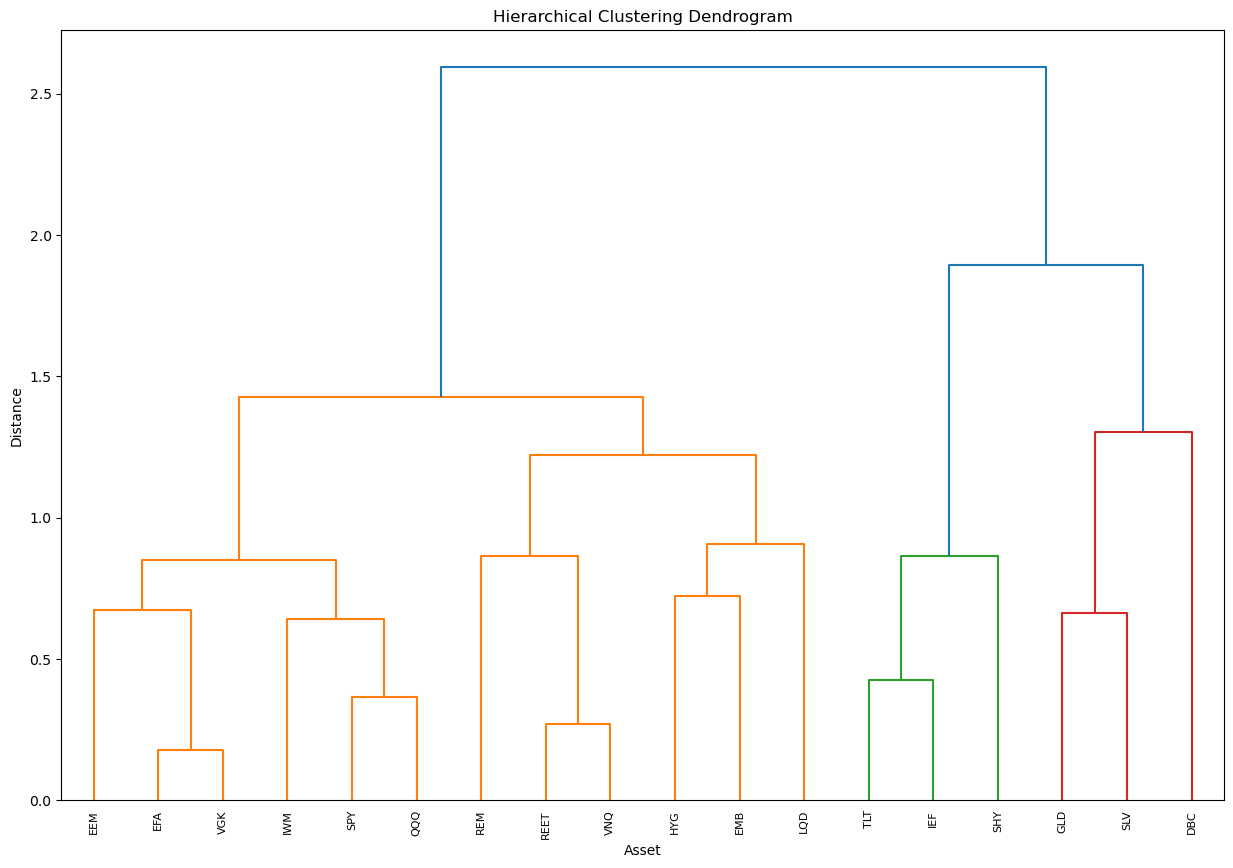

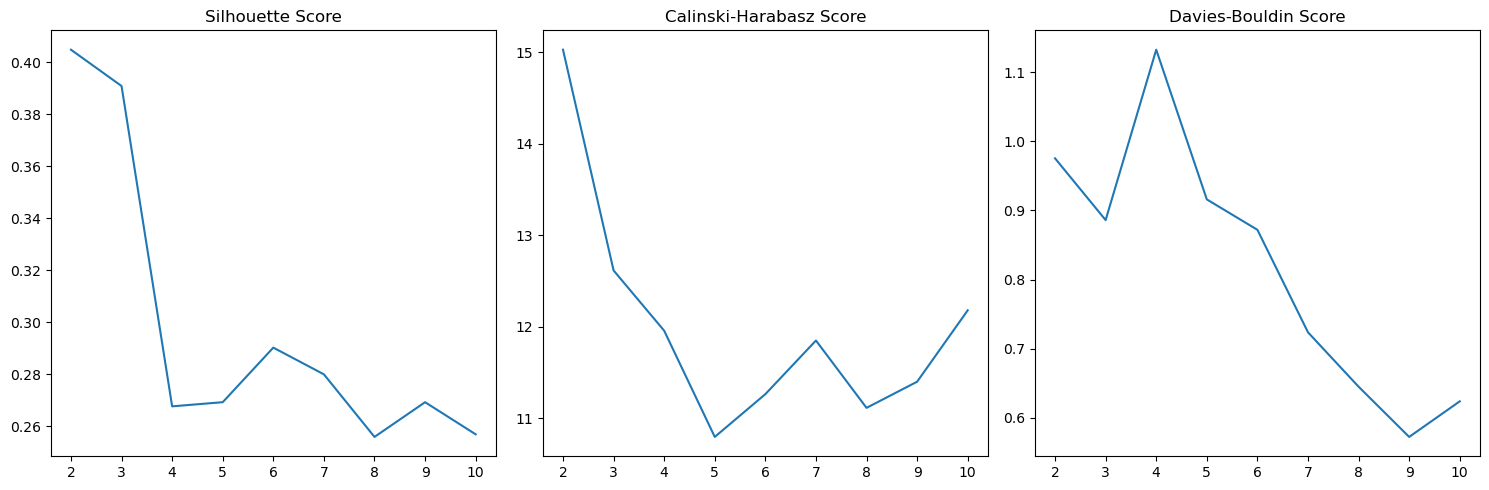

In [3]:

hca = HierarchicalClusterAnalysis()
    
# Define universe
tickers = [
    'SPY', 'QQQ', 'IWM',  # US Equity
    'EFA', 'EEM', 'VGK',  # International Equity
    'TLT', 'IEF', 'SHY',  # US Treasury
    'LQD', 'HYG', 'EMB',  # Credit
    'GLD', 'SLV', 'DBC',  # Commodities
    'VNQ', 'REET', 'REM'  # Real Estate
]

# Fetch data
returns = hca.fetch_data(tickers)

# Compute distances
distances = hca.compute_correlation_distance()

# Perform clustering
linkage_matrix = hca.perform_clustering(method='bottom_up')

# Plot dendrogram
dendrogram_plot = hca.plot_dynamic_dendrogram()

# Find optimal clusters
optimal_k = hca.find_optimal_clusters()
print(f"\nOptimal number of clusters: {optimal_k}")

# Analyze clusters
cluster_analysis = hca.analyze_clusters(optimal_k)
print("\nCluster Analysis:")
print(cluster_analysis)

# Additional visualization: Cluster correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    hca.correlation_matrix, 
    cmap='RdBu_r',
    center=0,
    annot=False
)
plt.title('Asset Correlation Heatmap')
plt.tight_layout()